In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.join('..','data_files')
clean_data = os.path.join(base_dir,'clean_data')
api_data = os.path.join(base_dir,'api_calls')
prep_data = os.path.join(base_dir,'prep_data')

lakes = ['Superior','Michigan','Huron','Erie','Ontario']

lake_colors_d = {'Superior':'blue',
                 'Michigan':'red',
                 'Huron':'green',
                 'Erie':'purple',
                 'Ontario':'orange'}

In [3]:
lake_stations = {}
for lake in lakes:
    file = f'{lake}_stations.csv'
    lake_stations[lake] = pd.read_csv(os.path.join(prep_data,file))['id'].tolist()
len(lake_stations)

5

In [5]:
total_api = pd.DataFrame()
for lake in lakes:
    file = f'{lake}_22-27_GSOM.csv'
    total_api = total_api.append(pd.read_csv(os.path.join(api_data,file)))
len(total_api)

149994

In [6]:
total_api['date'] = pd.to_datetime(total_api['date'])
total_api['year'] = total_api['date'].dt.year
total_api['month'] = total_api['date'].dt.month
total_api['day'] = total_api['date'].dt.day
total_api['period'] = total_api['year'].map(str)+'-'+total_api['month'].map(str)
total_api.head()

,Unnamed: 0,date,datatype,station,attributes,value,year,month,day,period
0,0,1996-12-01,DT32,GHCND:USC00200032,",0",25,1996,12,1,1996-12
1,1,1996-12-01,DT32,GHCND:USC00200128,"1,0",29,1996,12,1,1996-12
2,2,1996-12-01,DT32,GHCND:USC00200146,",0",30,1996,12,1,1996-12
3,3,1996-12-01,DT32,GHCND:USC00200197,"1,0",30,1996,12,1,1996-12
4,4,1996-12-01,DT32,GHCND:USC00200230,",0",27,1996,12,1,1996-12


In [7]:
lake_data = {}
for lake in lakes:
    lake_data[lake] = total_api[total_api['station'].isin(lake_stations[lake])]
len(lake_data['Erie'])

37155

In [33]:
d = {}
for datatype in total_api['datatype'].unique():
    d[datatype] = {}
    for lake in lakes:
        d[datatype][lake] = lake_data[lake][lake_data[lake]['datatype']==datatype]\
                    .groupby('period')\
                    .agg({'value':'median','station':'count'})\
                    .rename(columns={'value':datatype})

In [38]:
ice_coverage = pd.read_csv(os.path.join('..','data_files','ice_data','ice_coverage.csv'),index_col='Date')
ice_coverage

,Unnamed: 0,Superior,Michigan,Huron,Erie,Ontario,Weekday,Year,Month,Day
Date,,,,,,,,,,
1972-12-19,0,0.00,NaN,NaN,NaN,NaN,Tuesday,1972,12,19
1972-12-20,1,16.62,9.21,25.26,0.0,0.61,Wednesday,1972,12,20
1972-12-28,2,9.35,12.09,12.65,0.0,2.98,Thursday,1972,12,28
1973-01-02,3,13.03,6.53,22.00,3.4,2.80,Tuesday,1973,1,2
1973-01-09,4,29.69,21.55,31.30,25.4,21.40,Tuesday,1973,1,9
...,...,...,...,...,...,...,...,...,...,...
2016-05-01,2519,0.55,0.00,0.00,0.0,0.00,Sunday,2016,5,1
2016-05-02,2520,0.24,0.00,0.00,0.0,0.00,Monday,2016,5,2
2016-05-03,2521,0.24,0.00,0.00,0.0,0.00,Tuesday,2016,5,3


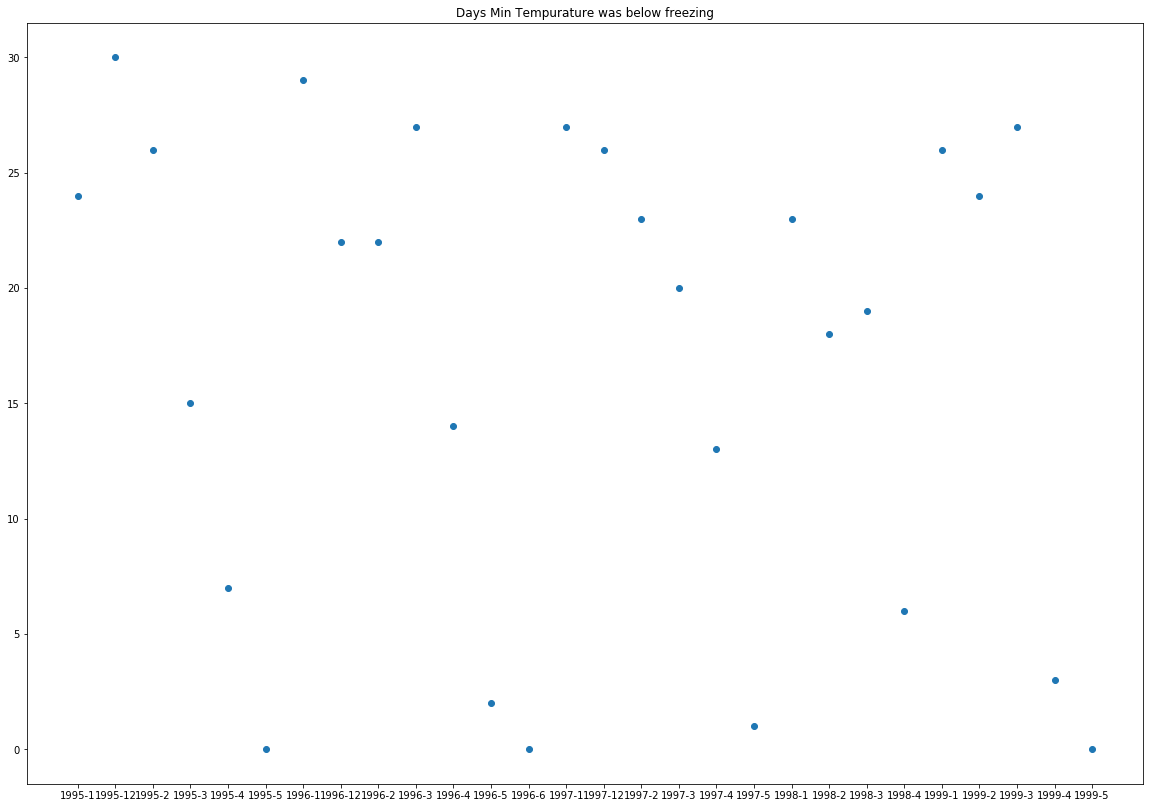

In [21]:
plt.figure(figsize=(20,14))
plt.title('Days Min Tempurature was below freezing')
#plt.xticks(np.arange(dt32['Erie'].index[0],dt32['Erie'].index[1]),rotation=45)
for lake in lakes:
    plt.scatter(dt32[lake].index,dt32[lake]['value'])
#plt.grid()
plt.show()